In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anjuy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
netflix_data=pd.read_csv('C:/Project/netflix_titles.csv')

In [3]:
netflix_data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [4]:
netflix_data.shape

(8807, 12)

In [5]:
selected_features = ['title','cast','type','listed_in','director']
selected_features

['title', 'cast', 'type', 'listed_in', 'director']

C:\Users\anjuy\AppData\Local\Temp\ipykernel_14784\1982161901.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41],
 [Text(0, 0, 'International Movies'),
  Text(0, 1, 'Dramas'),
  Text(0, 2, 'Comedies'),
  Text(0, 3, 'International TV Shows'),
  Text(0, 4, 'Documentaries'),
  Text(0, 5, 'Action & Adventure'),
  Text(0, 6, 'TV Dramas'),
  Text(0, 7, 'Independent Movies'),
  Text(0, 8, 'Children & Family Movies'),
  Text(0, 9, 'Romantic Movies'),
  Text(0, 10, 'TV Comedies'),
  Text(0, 11, 'Thrillers'),
  Text(0, 12, 'Crime TV Shows'),
  Text(0, 13, "Kids' TV"),
  Text(0, 14, 'Docuseries'),
  Text(0, 15, 'Music & Musicals'),
  Text(0, 16, 'Romantic TV Shows'),
  Text(0, 17, 'Horror Movies'),
  Text(0, 18, 'Stand-Up Comedy'),
  Text(0, 19, 'Reality TV'),
  Text(0, 20, 'British TV Shows'),
  Text(0, 21, 'Sci-Fi & Fantasy'),
  Text(0, 22, 'Sports Movies'),
  Text(0,

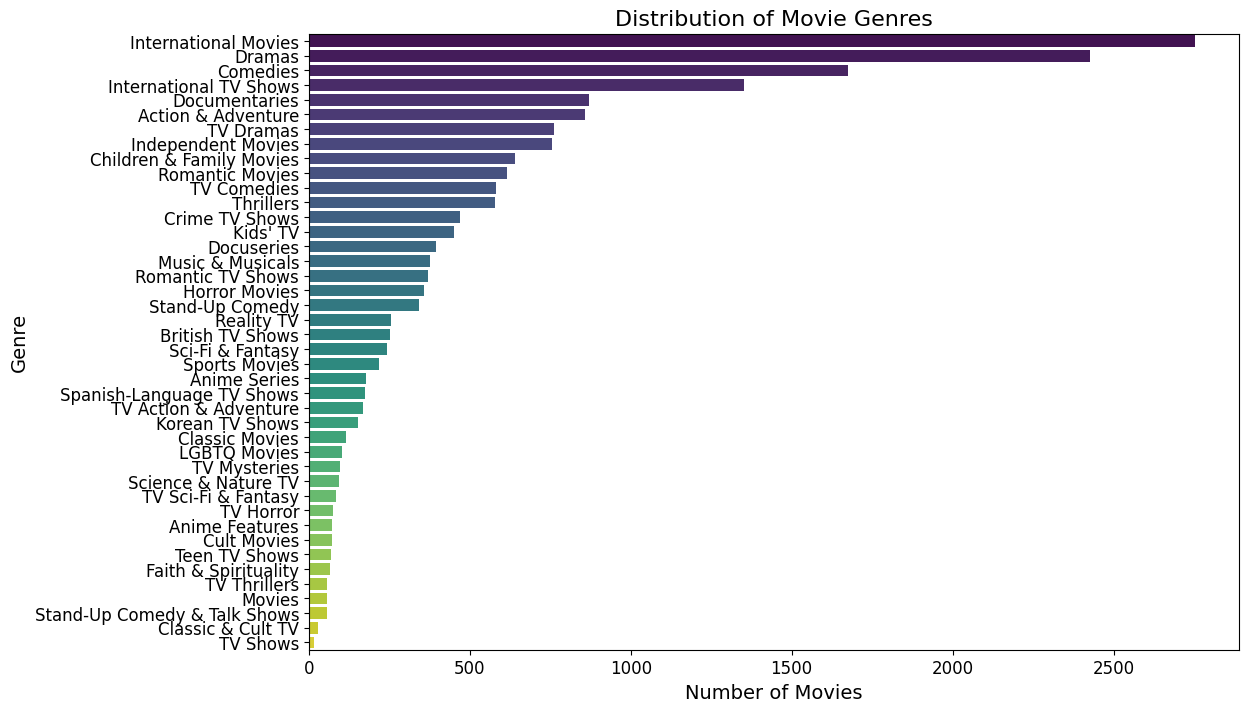

In [6]:
# Split genres into separate rows
df_genres = netflix_data['listed_in'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('listed_in')
df_genres['listed_in'] = df_genres['listed_in'].str.strip()  # Remove any leading/trailing whitespace

# Count the number of movies in each genre
genre_counts = df_genres['listed_in'].value_counts()

# Plot the counts
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Distribution of Movie Genres', fontsize=16)
plt.xlabel('Number of Movies', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [7]:
for feature in selected_features:
 netflix_data[feature]=netflix_data[feature].fillna('')

In [8]:
combined_features = netflix_data['listed_in']+' '+netflix_data['type']+' '+netflix_data['title']+' '+netflix_data['cast']+' '+netflix_data['director']
combined_features

0       Documentaries Movie Dick Johnson Is Dead  Kirs...
1       International TV Shows, TV Dramas, TV Mysterie...
2       Crime TV Shows, International TV Shows, TV Act...
3       Docuseries, Reality TV TV Show Jailbirds New O...
4       International TV Shows, Romantic TV Shows, TV ...
                              ...                        
8802    Cult Movies, Dramas, Thrillers Movie Zodiac Ma...
8803    Kids' TV, Korean TV Shows, TV Comedies TV Show...
8804    Comedies, Horror Movies Movie Zombieland Jesse...
8805    Children & Family Movies, Comedies Movie Zoom ...
8806    Dramas, International Movies, Music & Musicals...
Length: 8807, dtype: object

In [9]:
# Check for missing values
missing_values=netflix_data.isnull().sum()
print(missing_values)

show_id           0
type              0
title             0
director          0
cast              0
country         831
date_added       10
release_year      0
rating            4
duration          3
listed_in         0
description       0
dtype: int64


In [10]:
# Text normalization function
def text_preprocessing(text):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stop_words]
    return ' '.join(text)

# Apply text normalization to relevant columns
netflix_data['genre'] = netflix_data['listed_in'].apply(text_preprocessing)
netflix_data['cast'] = netflix_data['cast'].apply(text_preprocessing)
netflix_data['director'] = netflix_data['director'].apply(text_preprocessing)


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [12]:
feature_vectors=tfidf.fit_transform(combined_features)
feature_vectors

<8807x41370 sparse matrix of type '<class 'numpy.float64'>'
	with 210373 stored elements in Compressed Sparse Row format>

In [13]:
similarity = cosine_similarity(feature_vectors)
similarity

array([[1.        , 0.        , 0.        , ..., 0.00346338, 0.00324103,
        0.00288631],
       [0.        , 1.        , 0.04171844, ..., 0.        , 0.        ,
        0.00351582],
       [0.        , 0.04171844, 1.        , ..., 0.        , 0.        ,
        0.00209883],
       ...,
       [0.00346338, 0.        , 0.        , ..., 1.        , 0.07596495,
        0.00433972],
       [0.00324103, 0.        , 0.        , ..., 0.07596495, 1.        ,
        0.00406112],
       [0.00288631, 0.00351582, 0.00209883, ..., 0.00433972, 0.00406112,
        1.        ]])

In [14]:
list_of_all_titles = netflix_data['title'].str.split(',').explode().str.strip().unique().tolist()
list_of_all_types = netflix_data['type'].str.split(',').explode().str.strip().unique().tolist()
list_of_all_genres = netflix_data['listed_in'].str.split(',').explode().str.strip().unique().tolist()
list_of_all_directors = netflix_data['director'].dropna().str.split(',').explode().str.strip().unique().tolist()
list_of_all_cast = netflix_data['cast'].dropna().str.split(',').explode().str.strip().unique().tolist()
list_of_all_titles

['Dick Johnson Is Dead',
 'Blood & Water',
 'Ganglands',
 'Jailbirds New Orleans',
 'Kota Factory',
 'Midnight Mass',
 'My Little Pony: A New Generation',
 'Sankofa',
 'The Great British Baking Show',
 'The Starling',
 'Vendetta: Truth',
 'Lies and The Mafia',
 'Bangkok Breaking',
 'Je Suis Karl',
 'Confessions of an Invisible Girl',
 'Crime Stories: India Detectives',
 'Dear White People',
 "Europe's Most Dangerous Man: Otto Skorzeny in Spain",
 'Falsa identidad',
 'Intrusion',
 'Jaguar',
 'Monsters Inside: The 24 Faces of Billy Milligan',
 'Resurrection: Ertugrul',
 'Avvai Shanmughi',
 'Go! Go! Cory Carson: Chrissy Takes the Wheel',
 'Jeans',
 'Love on the Spectrum',
 'Minsara Kanavu',
 'Grown Ups',
 'Dark Skies',
 'Paranoia',
 'Ankahi Kahaniya',
 'Chicago Party Aunt',
 'Sex Education',
 'Squid Game',
 'Tayo and Little Wizards',
 'The Father Who Moves Mountains',
 'The Stronghold',
 'Angry Birds',
 'Birth of the Dragon',
 'Chhota Bheem',
 'He-Man and the Masters of the Universe',
 'J

In [15]:
list_of_all_genres

['Documentaries',
 'International TV Shows',
 'TV Dramas',
 'TV Mysteries',
 'Crime TV Shows',
 'TV Action & Adventure',
 'Docuseries',
 'Reality TV',
 'Romantic TV Shows',
 'TV Comedies',
 'TV Horror',
 'Children & Family Movies',
 'Dramas',
 'Independent Movies',
 'International Movies',
 'British TV Shows',
 'Comedies',
 'Spanish-Language TV Shows',
 'Thrillers',
 'Romantic Movies',
 'Music & Musicals',
 'Horror Movies',
 'Sci-Fi & Fantasy',
 'TV Thrillers',
 "Kids' TV",
 'Action & Adventure',
 'TV Sci-Fi & Fantasy',
 'Classic Movies',
 'Anime Features',
 'Sports Movies',
 'Anime Series',
 'Korean TV Shows',
 'Science & Nature TV',
 'Teen TV Shows',
 'Cult Movies',
 'TV Shows',
 'Faith & Spirituality',
 'LGBTQ Movies',
 'Stand-Up Comedy',
 'Movies',
 'Stand-Up Comedy & Talk Shows',
 'Classic & Cult TV']

In [16]:
list_of_all_directors

['kirsten johnson',
 '',
 'julien leclercq',
 'mike flanagan',
 'robert cullen',
 'josé lui ucha',
 'hail gerima',
 'andi devonshir',
 'theodor melfi',
 'kongkiat komesiri',
 'christian schwochow',
 'bruno garotti',
 'pedro de echav garcía',
 'pablo azorín william',
 'adam salki',
 'olivi megaton',
 'k.s. ravikumar',
 'alex woo',
 'stanley moor',
 's. shankar',
 'rajiv menon',
 'denni dugan',
 'scott stewart',
 'robert luket',
 'ashwini iyer tiwari',
 'abhishek chaubey',
 'saket chaudhari',
 'daniel sandu',
 'cédric jimenez',
 'georg nolfi',
 'steven spielberg',
 'jeannot szwarc',
 'joe alv',
 'joseph sargent',
 'tyler greco',
 'daniel espinosa',
 'bunmi ajakaiy',
 'antoin fuqua',
 'toshiya shinohara',
 'masahiko murata',
 'hajim kamegaki',
 'hirotsugu kawasaki',
 'toshiyuki tsuru',
 'tensai okamura',
 'david yaroveski',
 'hanns-bruno kammertöns',
 'vanessa nöcker',
 'michael wech',
 'david a. varga',
 'kemi adetiba',
 'ben simm',
 'prakash satam',
 'delhiprasad deenadayalan',
 'tomer 

In [17]:
list_of_all_cast

['',
 'ama qamata',
 'khosi ngema',
 'gail mabalane',
 'thabang molaba',
 'dillon windvogel',
 'natasha thahane',
 'arno greeff',
 'xolil tshabalala',
 'getmor sithole',
 'cindi mahlangu',
 'ryle de morny',
 'grete fincham',
 'sello maak ka-ncube',
 'odwa gwanya',
 'mekaila mathys',
 'sandi schultz',
 'duan williams',
 'shamilla miller',
 'patrick mofokeng',
 'sami bouajila',
 'traci gotoas',
 'samuel jouy',
 'nabiha akkari',
 'sofia lesaffre',
 'salim kechiouche',
 'noureddin farihi',
 'geert van rampelberg',
 'bakari diombera',
 'mayur more',
 'jitendra kumar',
 'ranjan raj',
 'alam khan',
 'ahsaa channa',
 'revathi pillai',
 'urvi singh',
 'arun kumar',
 'kate siegel',
 'zach gilford',
 'hamish linklater',
 'henri thomas',
 'kristin lehman',
 'samantha sloyan',
 'igbi rigney',
 'rahul kohli',
 'annarah cymone',
 'annabeth gish',
 'alex essoe',
 'rahul abburi',
 'matt biedel',
 'michael trucco',
 'crystal balint',
 'loui oliv',
 'vanessa hudgens',
 'kimiko glenn',
 'jame marsden',
 '

In [18]:
list_of_all_types

['Movie', 'TV Show']

In [27]:
from fuzzywuzzy import process
def find_closest_match(input_value, list_of_values):
    matches = []
    for word in input_value.split():
        match = process.extractOne(word, list_of_values)
        if match:
            matches.append(match[0])
    return ', '.join(set(matches))

# Input favorite movie genre
genre = input('What are you in the mood for today🤔(genre): ')

# Get unique genres from the dataset
unique_genres = set()
netflix_data['listed_in'].dropna().apply(lambda x: unique_genres.update(x.split(', ')))

# Convert set to list
list_of_all_genres = list(unique_genres)

# Find closest match for genre
closest_genre = find_closest_match(genre, list_of_all_genres)
print('Closest genre match:', closest_genre)

# Input director name
director = input('Enter the director name: ')

# Get unique directors from the dataset
unique_directors = set()
netflix_data['director'].dropna().apply(lambda x: unique_directors.update(x.split(', ')))

# Convert set to list
list_of_all_directors = list(unique_directors)

# Find closest match for director
closest_director = find_closest_match(director, list_of_all_directors)
print('Closest director match:', closest_director)

# Input cast name
cast = input('Enter the cast name: ')

# Get unique cast from the dataset
unique_cast = set()
netflix_data['cast'].dropna().apply(lambda x: unique_cast.update(x.split(', ')))

# Convert set to list
list_of_all_cast = list(unique_cast)

# Find closest match for cast
closest_cast = find_closest_match(cast, list_of_all_cast)
print('Closest cast match:', closest_cast)

# Filter dataset based on closest matches
if closest_genre and closest_director and closest_cast:
    recommended_movies = netflix_data[
        (netflix_data['listed_in'].str.contains(closest_genre, na=False)) &
        (netflix_data['director'].str.contains(closest_director, na=False)) &
        (netflix_data['cast'].str.contains(closest_cast, na=False))
    ]
else:
    # If no match found for all three, filter based on director or cast alone
    recommended_movies = netflix_data[
        (netflix_data['director'].str.contains(closest_director, na=False)) |
        (netflix_data['cast'].str.contains(closest_cast, na=False))
    ]

# Optionally, sort or select top movies based on specific criteria
if not recommended_movies.empty:
    top_recommendations = recommended_movies.head(5)['title'].tolist()
    print("\nTop 5 recommended movies:")
    for movie in top_recommendations:
        print("-", movie)
else:
    print("\nsome movies related to the genre or director or cast:")
    related_movies = netflix_data[
        (netflix_data['director'].str.contains(closest_director, na=False)) |
        (netflix_data['cast'].str.contains(closest_cast, na=False))
    ]
    if not related_movies.empty:
        top_related = related_movies.head(5)['title'].tolist()
        for movie in top_related:
            print("-", movie)
    else:
        print("No related movies found.")


What are you in the mood for today🤔(genre):  drama


Closest genre match: Dramas


Enter the director name:  maniratnam


Closest director match: mani ratnam


Enter the cast name:  aishwarya rai


Closest cast match: aishwarya, wendi craig

some movies related to the genre or director or cast:
- Bombay
- O Kadhal Kanmani
- Dil Se
- Guru
- Yuva


In [28]:
from fuzzywuzzy import process

# Function to find the closest match for the director's name
def find_closest_match(input_value, list_of_values):
    matches = []
    for word in input_value.split():
        match = process.extractOne(word, list_of_values)
        if match:
            matches.append(match[0])
    return ', '.join(set(matches))

# Input director name
director = input('Enter the director name: ')

# Get unique directors from the dataset
unique_directors = set()
netflix_data['director'].dropna().apply(lambda x: unique_directors.update(x.split(', ')))

# Convert set to list
list_of_all_directors = list(unique_directors)

# Find closest match for director
closest_director = find_closest_match(director, list_of_all_directors)
print('Closest director match:', closest_director)

# Filter dataset based on the closest director match
filtered_movies = netflix_data[netflix_data['director'].str.contains(closest_director, na=False)]

# Display the filtered movies
if not filtered_movies.empty:
    print("\nMovies directed by", closest_director, ":")
    for movie in filtered_movies['title']:
        print("-", movie)
else:
    print(f"No movies found for director: {closest_director}")

Enter the director name:  maniratnam


Closest director match: mani ratnam

Movies directed by mani ratnam :
- Bombay
- O Kadhal Kanmani
- Dil Se
- Guru
- Yuva


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score
actual = ['Guru','Dil Se','Bombay','O Kadhal Kanmani','Yuva']
predicted = ['Dil Se','Bombay','O Kadhal Kanmani','Guru','Yuva']  # These should match if everything is correct

# Assuming binary relevance (1 if relevant, 0 if not)
y_true = [1 if movie in actual else 0 for movie in predicted]
y_pred = [1 if movie in predicted else 0 for movie in actual]

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


Precision: 1.00
Recall: 1.00
F1 Score: 1.00
